Import Libraries

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score


In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the dataset

In [26]:
train_path = "./Datasets/train.csv"
test_path = "./Datasets/test.csv"
output_path = "./Datasets/output.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

See train data distribution

In [27]:
train_data.shape

(60000, 16)

In [28]:
train_data.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


In [29]:
train_data.nunique()

rent_approval_date       31
town                     26
block                  2553
street_name            1083
flat_type                 9
flat_model               19
floor_area_sqm          146
furnished                 1
lease_commence_date      54
latitude               8612
longitude              8612
elevation                 1
subzone                 152
planning_area            29
region                    5
monthly_rent            113
dtype: int64

In [30]:
train_data.isna().sum()

rent_approval_date     0
town                   0
block                  0
street_name            0
flat_type              0
flat_model             0
floor_area_sqm         0
furnished              0
lease_commence_date    0
latitude               0
longitude              0
elevation              0
subzone                0
planning_area          0
region                 0
monthly_rent           0
dtype: int64

Data preprocessing of train_data

In [31]:
def data_preprocessing(data):
    data.replace("-", " ", regex=True, inplace=True)

    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].str.lower()
    
    data['lease_commence_date'] = 2021 - data['lease_commence_date']

    def convert_to_numeric(date_str):
        year, month = date_str.split(" ")
        return float(year) + float(month)/12.0
    data['rent_approval_date'] = [convert_to_numeric(date) for date in data['rent_approval_date']]

    # data = data.drop_duplicates()
    # data = data.reset_index(drop=True)
    
    return data

train_data = data_preprocessing(train_data)
train_data


,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021.750000,jurong east,257,jurong east street 24,3 room,new generation,67.0,yes,38,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022.416667,bedok,119,bedok north road,4 room,new generation,92.0,yes,43,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022.833333,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,50,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021.666667,pasir ris,250,pasir ris street 21,executive,apartment,149.0,yes,28,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022.916667,kallang/whampoa,34,whampoa west,3 room,improved,68.0,yes,49,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021.750000,ang mo kio,441,ang mo kio avenue 10,3 room,new generation,67.0,yes,42,1.366050,103.854168,0.0,chong boon,ang mo kio,north east region,2200
59996,2023.333333,bukit merah,95a,henderson road,4 room,model a,83.0,yes,2,1.286493,103.821434,0.0,henderson hill,bukit merah,central region,4100
59997,2022.500000,tampines,862a,tampines street 83,5 room,improved,122.0,yes,33,1.355064,103.936507,0.0,tampines west,tampines,east region,2250
59998,2023.083333,bedok,67,bedok sth avenue 3,5 room,standard,123.0,yes,44,1.318974,103.944076,0.0,bedok south,bedok,east region,4700


Feature Engineering of train_data

In [32]:
X_train_num = train_data.select_dtypes(include = ['float64', 'int64'])
print(X_train_num.shape)
X_train_num.head()

(60000, 7)


,rent_approval_date,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,monthly_rent
0,2021.750000,67.0,38,1.344518,103.738630,0.0,1600
1,2022.416667,92.0,43,1.330186,103.938717,0.0,2250
2,2022.833333,67.0,50,1.332242,103.845643,0.0,1900
3,2021.666667,149.0,28,1.370239,103.962894,0.0,2850
4,2022.916667,68.0,49,1.320502,103.863341,0.0,2100


In [33]:
X_train_cat = train_data.select_dtypes(include = ['object'])
print(X_train_cat.shape)
X_train_cat.head()

(60000, 9)


,town,block,street_name,flat_type,flat_model,furnished,subzone,planning_area,region
0,jurong east,257,jurong east street 24,3 room,new generation,yes,yuhua east,jurong east,west region
1,bedok,119,bedok north road,4 room,new generation,yes,bedok north,bedok,east region
2,toa payoh,157,lorong 1 toa payoh,3 room,improved,yes,toa payoh central,toa payoh,central region
3,pasir ris,250,pasir ris street 21,executive,apartment,yes,pasir ris drive,pasir ris,east region
4,kallang/whampoa,34,whampoa west,3 room,improved,yes,bendemeer,kallang,central region


In [34]:
print(X_train_cat.groupby('flat_model').size())


flat_model
2 room                       34
3gen                          3
adjoined flat                49
apartment                  2080
dbss                        371
improved                  17010
maisonette                  956
model a                   17122
model a maisonette           56
model a2                    663
new generation            11292
premium apartment          5109
premium apartment loft       25
premium maisonette            6
simplified                 2798
standard                   2268
terrace                       4
type s1                     108
type s2                      46
dtype: int64


array([[<AxesSubplot:title={'center':'rent_approval_date'}>,
        <AxesSubplot:title={'center':'floor_area_sqm'}>,
        <AxesSubplot:title={'center':'lease_commence_date'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'elevation'}>],
       [<AxesSubplot:title={'center':'monthly_rent'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

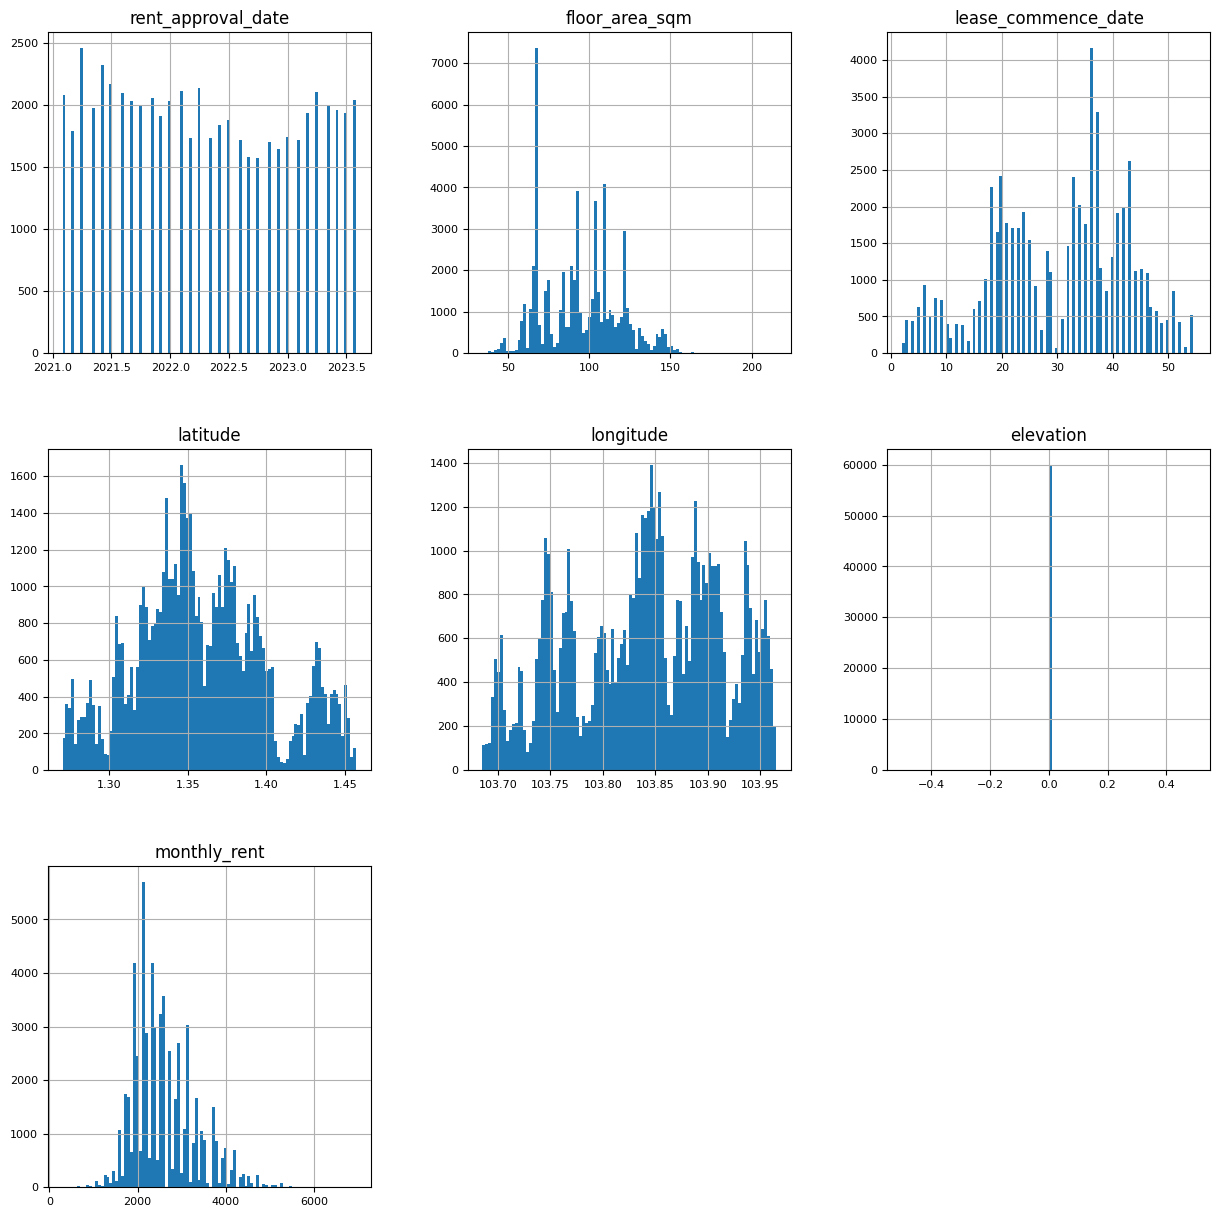

In [35]:
X_train_num.hist(figsize=(15, 15), bins=100, xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

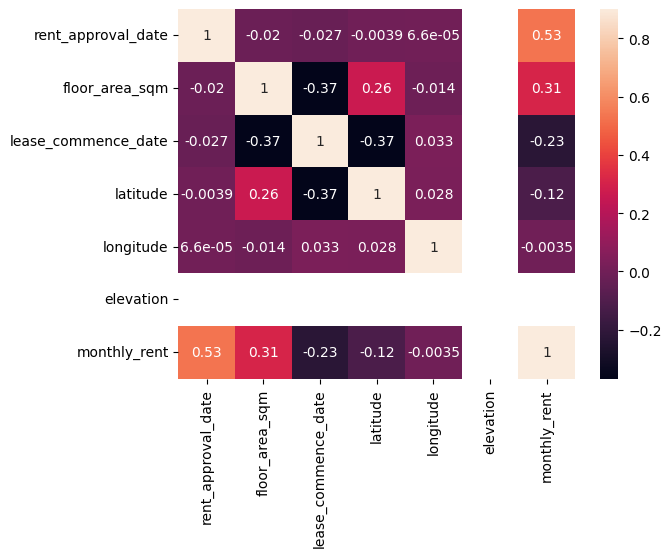

In [36]:
corrmat = X_train_num.corr()
sns.heatmap(corrmat, vmax=.9, annot=True)

count    60000.000000
mean      2590.328333
std        714.910468
min        300.000000
25%       2100.000000
50%       2400.000000
75%       3000.000000
max       6950.000000
Name: monthly_rent, dtype: float64


<Figure size 640x480 with 0 Axes>

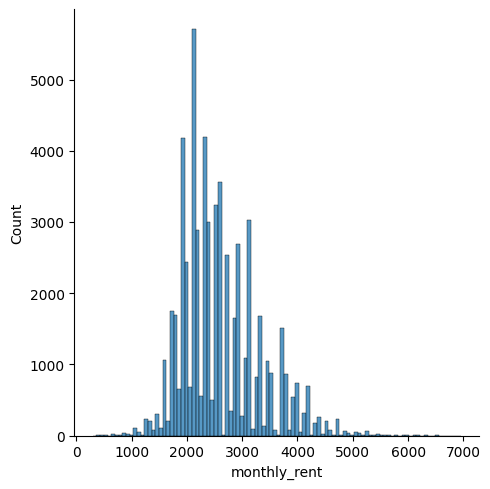

In [37]:
y_train = train_data['monthly_rent']
print(y_train.describe())
plt.figure()
sns.displot(y_train, bins=100)

In [38]:
def feature_engineering(data):
    # numerical feature
    data_num = data.select_dtypes(include = ['float64', 'int64'])
    data_num = data_num[['rent_approval_date', 'floor_area_sqm', 'lease_commence_date']]

    # categorical feature
    data_cat = data.select_dtypes(include = ['object'])
    data_cat_one_hot = pd.get_dummies(data[['flat_type', 'flat_model', 'region', 'planning_area']]) # , 'planning_area', 'town'

    # Concate all the choosed features
    data_filter = pd.concat([data_num, data_cat_one_hot], axis=1)

    return data_filter

X_train = feature_engineering(train_data)
X_train
    

,rent_approval_date,floor_area_sqm,lease_commence_date,flat_type_2 room,flat_type_3 room,flat_type_4 room,flat_type_5 room,flat_type_executive,flat_model_2 room,flat_model_3gen,...,planning_area_punggol,planning_area_queenstown,planning_area_rochor,planning_area_sembawang,planning_area_sengkang,planning_area_serangoon,planning_area_tampines,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun
0,2021.750000,67.0,38,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022.416667,92.0,43,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022.833333,67.0,50,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2021.666667,149.0,28,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022.916667,68.0,49,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021.750000,67.0,42,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,2023.333333,83.0,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,2022.500000,122.0,33,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
59998,2023.083333,123.0,44,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Start to train

### Training preparation

#### Train-Test Split

In [39]:
X, y = X_train, y_train
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Define evaluation metrics

In [40]:
# def rmse_cv(model):
#     rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
#     return rmse

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    r_squared = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    
    print("MAE:", mae)
    print("R2 Score:", r_squared)
    print("MSE:", mse)
    print("RMSE:", rmse)
    

### Linear Models

#### Linear Regression(Ordinary Least Squares)

In [41]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 389.4673179112316
R2 Score: 0.49383995781108025
MSE: 255345.57614070852
RMSE: 505.3173024355178


#### Ridge Regression

In [42]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)

evaluation(y_test, predictions)

MAE: 389.4461586925136
R2 Score: 0.4938922236716695
MSE: 255319.2092702086
RMSE: 505.2912123421588


#### Lasso Regression

In [43]:
lasso = Lasso()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)

evaluation(y_test, predictions)

MAE: 390.83298729480794
R2 Score: 0.4898978228403542
MSE: 257334.2884874425
RMSE: 507.28127157174106


#### Elastic-Net Regression

In [44]:
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)
predictions = elastic_net.predict(X_test)

evaluation(y_test, predictions)

MAE: 442.0373550746713
R2 Score: 0.35741622529182526
MSE: 324168.07036357955
RMSE: 569.3575944549958


#### Stochastic Gradient Descent - SGD

In [45]:
scaler = StandardScaler()
X_train_sgd = scaler.fit_transform(X_train)
X_test_sgd = scaler.transform(X_test)

sgd = SGDRegressor(loss="epsilon_insensitive")
sgd.fit(X_train_sgd, y_train)
predictions = sgd.predict(X_test_sgd)

evaluation(y_test, predictions)

MAE: 389.45259691409115
R2 Score: 0.4862159846909889
MSE: 259191.68734382166
RMSE: 509.10871858947934


#### Polynomial regression

In [46]:
poly_reg = PolynomialFeatures(degree=2)
X_train_2d = poly_reg.fit_transform(X_train)
X_test_2d = poly_reg.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_2d, y_train)
predictions = lin_reg.predict(X_test_2d)

evaluation(y_test, predictions)

MAE: 502.61256955940524
R2 Score: -116.51195058969051
MSE: 59281954.76865293
RMSE: 7699.477564656769


### Support Vector Machines

#### Support Vector Regression

In [47]:
svr = SVR(C=200000)
svr.fit(X_train, y_train)
predictions = svr.predict(X_test)

evaluation(y_test, predictions)

MAE: 408.39520862934364
R2 Score: 0.4338331164671144
MSE: 285617.5853832715
RMSE: 534.4320212929531


### Nearest Neighbors

#### Nearest Neighbors Regression

In [48]:
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)

knn_reg = KNeighborsRegressor(n_neighbors=20)
knn_reg.fit(X_train_nn, y_train)
predictions = knn_reg.predict(X_test_nn)

evaluation(y_test, predictions)

MAE: 378.35625
R2 Score: 0.5015464719052061
MSE: 251457.825
RMSE: 501.4557059202737


### Decision Tree

#### DecisionTreeRegressor

In [49]:
tree_reg = DecisionTreeRegressor(max_depth=10,min_samples_leaf=50)
tree_reg.fit(X_train, y_train)
predictions = tree_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 377.76200714931764
R2 Score: 0.5077963872752971
MSE: 248304.8929074053
RMSE: 498.30200973647027


### Ensemble Methods

#### Gradient-boosted trees

In [70]:
hist_reg = HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.01)
hist_reg.fit(X_train, y_train)
predictions = hist_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 367.34959663481885
R2 Score: 0.5338858146947396
MSE: 235143.40381239628
RMSE: 484.91587292271254


#### Random Forest

In [51]:
random_forest = RandomForestRegressor(n_estimators=1200,max_depth=15,min_samples_split=5,min_samples_leaf=5,max_features=None,oob_score=True)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

evaluation(y_test, predictions)

MAE: 370.74586175055583
R2 Score: 0.5200293615364118
MSE: 242133.65140222752
RMSE: 492.0707788542493


#### BaggingRegressor

In [52]:
bag_reg = BaggingRegressor(n_estimators=100)
bag_reg.fit(X_train, y_train)
predictions = bag_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 404.013242792797
R2 Score: 0.421280250718412
MSE: 291950.2044556064
RMSE: 540.3241660851442


#### AdaBoost Regressor

In [53]:
base_reg = LinearRegression()
ada_reg = AdaBoostRegressor(base_estimator=base_reg, n_estimators=1000)
ada_reg.fit(X_train, y_train)
predictions = ada_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 391.7104991024138
R2 Score: 0.48988622484358446
MSE: 257340.1393980644
RMSE: 507.2870384684241


#### XGBoost Regressor

In [63]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

evaluation(y_test, predictions)

MAE: 367.72458495585124
R2 Score: 0.5316472910841791
MSE: 236272.68517283566
RMSE: 486.07888780817837


#### Voting Regressor(Blend different regressors)

In [72]:
voting_reg = VotingRegressor(estimators=[('hist', hist_reg), ('xgb', xgb),("random_forest",random_forest)])
voting_reg.fit(X_train, y_train)
predictions = voting_reg.predict(X_test)

evaluation(y_test, predictions)


MAE: 367.1380249678457
R2 Score: 0.5323898381561487
MSE: 235898.08802153997
RMSE: 485.693409489505


### Neural network models (supervised)

#### MLP Regressor

In [56]:
mlp_reg = MLPRegressor()
mlp_reg.fit(X_train, y_train)
predictions = mlp_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 504.70593314571283
R2 Score: 0.20525444676324978
MSE: 400930.03054705873
RMSE: 633.1903588551066


## Predict on test data

Predicet test dataset

In [57]:
test_data = data_preprocessing(test_data)
test_data = feature_engineering(test_data)

test_data

,rent_approval_date,floor_area_sqm,lease_commence_date,flat_type_2 room,flat_type_3 room,flat_type_4 room,flat_type_5 room,flat_type_executive,flat_model_2 room,flat_model_adjoined flat,...,planning_area_punggol,planning_area_queenstown,planning_area_rochor,planning_area_sembawang,planning_area_sengkang,planning_area_serangoon,planning_area_tampines,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun
0,2023.083333,121.0,37,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022.750000,100.0,22,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2023.583333,91.0,41,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021.666667,74.0,35,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022.250000,121.0,38,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2022.666667,92.0,9,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
29996,2023.166667,90.0,17,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
29997,2023.416667,68.0,41,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29998,2023.166667,144.0,23,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [58]:
test_data = test_data.reindex(columns=X_train.columns, fill_value=False)

test_data

,rent_approval_date,floor_area_sqm,lease_commence_date,flat_type_2 room,flat_type_3 room,flat_type_4 room,flat_type_5 room,flat_type_executive,flat_model_2 room,flat_model_3gen,...,planning_area_punggol,planning_area_queenstown,planning_area_rochor,planning_area_sembawang,planning_area_sengkang,planning_area_serangoon,planning_area_tampines,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun
0,2023.083333,121.0,37,0,0,0,1,0,0,False,...,0,0,0,0,0,0,0,0,0,0
1,2022.750000,100.0,22,0,0,1,0,0,0,False,...,0,0,0,1,0,0,0,0,0,0
2,2023.583333,91.0,41,0,0,1,0,0,0,False,...,0,0,0,0,0,0,0,0,0,0
3,2021.666667,74.0,35,0,1,0,0,0,0,False,...,0,0,0,0,0,0,0,0,0,0
4,2022.250000,121.0,38,0,0,0,1,0,0,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2022.666667,92.0,9,0,0,1,0,0,0,False,...,1,0,0,0,0,0,0,0,0,0
29996,2023.166667,90.0,17,0,0,1,0,0,0,False,...,0,0,0,1,0,0,0,0,0,0
29997,2023.416667,68.0,41,0,1,0,0,0,0,False,...,0,0,0,0,0,0,0,0,0,0
29998,2023.166667,144.0,23,0,0,0,0,1,0,False,...,0,0,0,0,0,0,0,0,1,0


In [59]:
best_model = hist_reg

test_pred = best_model.predict(test_data)
test_pred

array([3238.86561229, 2690.90077072, 3596.20225647, ..., 2657.57214498,
       3275.05348721, 3521.52258293])

In [60]:
sample_submission_path = './Datasets/example-submission.csv'
sample_submission_df = pd.read_csv(sample_submission_path)
sample_submission_df['Predicted'] = test_pred
sample_submission_df.to_csv('./Datasets/submission.csv', index=False)
sample_submission_df.head()

,Id,Predicted
0,0,3238.865612
1,1,2690.900771
2,2,3596.202256
3,3,1910.589106
4,4,2783.890257
